In [2]:
# Cell 1: 匯入套件與設定字體 (加強中文處理)
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns # 新增 seaborn
from pathlib import Path # 新增 pathlib
from datetime import datetime # 新增 datetime

# --- Seaborn 風格設定 (應放在字體設定之前) ---
sns.set_theme(style="darkgrid", palette="colorblind")

# --- 字體設定 ---
# 1. 指定字體列表 (優先使用微軟正黑體)
#    請確認 'Microsoft JhengHei' 是您系統上正確的名稱
font_list = ['Microsoft JhengHei', 'PingFang TC', 'SimHei', 'Arial Unicode MS']
plt.rcParams['font.sans-serif'] = font_list

# 2. 解決 負號(-) 顯示為方塊的問題
plt.rcParams['axes.unicode_minus'] = False

# 3. 檢查字體是否成功設定 (可取消註解來測試)
try:
    # 嘗試找列表中的第一個字體
    fm.findfont(fm.FontProperties(family=font_list[0]))
    print(f"字體 '{font_list[0]}' 設定成功。")
    # --- 測試繪圖 ---
    # fig, ax = plt.subplots()
    # ax.plot([1, 2, 3], [10, -5, 2])
    # ax.set_title("中文標題測試")
    # ax.set_xlabel("X 軸標籤")
    # ax.set_ylabel("Y 軸標籤")
    # plt.show()
    # plt.close(fig) # 關閉測試圖
except:
    print(f"警告：找不到主要的字體 '{font_list[0]}'。圖表中文可能無法正常顯示。")
    print("請檢查字體是否已安裝，且名稱是否正確。")

# --- 圖片輸出資料夾 ---
OUTDIR = Path("./backtest_plots") / datetime.now().strftime("%Y%m%d_%H%M%S")
OUTDIR.mkdir(parents=True, exist_ok=True)
print(f"圖表將儲存於: {OUTDIR}")



字體 'Microsoft JhengHei' 設定成功。
圖表將儲存於: backtest_plots\20251029_210127


In [3]:
try:
    df = pd.read_excel("Y9999 加權指數.xlsx", header=1)
except FileNotFoundError:
    print("錯誤：找不到檔案。請確認檔案路徑。")
    # 如果找不到檔案，後續程式碼會出錯，這裡可以選擇停止或給 df 一個空值
    df = pd.DataFrame() # 給一個空 DataFrame 避免 NameError


if not df.empty:
    # 選取需要的欄位
    data = df.iloc[:, 0:6]

    # 檢查資料型態和缺失值
    print("\n--- 原始資料型態 ---")
    print(data.dtypes)
    print("\n--- 原始資料缺失值 ---")
    print(data.isna().sum())
    # 清理欄位名稱中的潛在空格
    data.columns = data.columns.str.strip()
else:
    print("因無法載入資料，後續處理將跳過。")


--- 原始資料型態 ---
年月日         object
開盤價(元)     float64
最高價(元)     float64
最低價(元)     float64
收盤價(元)     float64
成交量(千股)      int64
dtype: object

--- 原始資料缺失值 ---
年月日        0
開盤價(元)     0
最高價(元)     0
最低價(元)     0
收盤價(元)     0
成交量(千股)    0
dtype: int64


In [4]:
# ========== 技術指標計算 =========

import pandas as pd # 確保 pandas 已匯入
import numpy as np  # 確保 numpy 已匯入

def KD_indicator(df, n=9, m1=3, m2=3):
    """計算 KD 指標"""
    low_min = df['最低價(元)'].rolling(window=n, min_periods=1).min() # min_periods=1 處理初期
    high_max = df['最高價(元)'].rolling(window=n, min_periods=1).max()
    high_low_diff = high_max - low_min
    RSV = ((df['收盤價(元)'] - low_min) / high_low_diff * 100).fillna(50) # fillna 處理初始 NaN 或分母為零
    K = RSV.ewm(com=m1-1, adjust=False).mean()
    D = K.ewm(com=m2-1, adjust=False).mean()
    df['K'] = K
    df['D'] = D
    return df

def MACD_indicator(df, short=12, long=26, signal=9):
    """計算 MACD 指標"""
    ema_short = df['收盤價(元)'].ewm(span=short, adjust=False).mean()
    ema_long = df['收盤價(元)'].ewm(span=long, adjust=False).mean()
    # DIF = MACD 線
    macd_line = ema_short - ema_long
    # DIF 的 EMA = Signal 線 
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    # Histogram (柱狀圖)
    histogram = macd_line - signal_line

    df['MACD'] = macd_line       # MACD 線 (快線-慢線)
    df['MACD_signal'] = signal_line # 訊號線 (MACD線的EMA)
    df['MACD_OSC'] = histogram      # MACD 柱狀圖 (MACD線 - 訊號線)
    return df

def RSI_indicator(df, period=14):
    """計算 RSI 指標 """
    delta = df['收盤價(元)'].diff()
    # 分開計算 gain 和 loss 的平均值
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    # 計算 RS 和 RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # 處理 avg_loss 為 0 的情況 (rsi 會變成 inf) 和初始 NaN
    # 當 avg_loss 為 0 (表示持續上漲)，rs 為 inf, rsi 應為 100
    df['RSI'] = rsi.replace([np.inf, -np.inf], 100).fillna(50) # inf 設 100, 初始 NaN 設 50
    return df

print(f"完成計算技術指標。")

完成計算技術指標。


In [5]:
# Cell 3: 數據前處理 + 【新增】技術指標訊號 + 特徵工程 (合併修改您原檔案的 Cell 3)
if not df.empty: # 確保 df 已成功載入
    # ========== 數據前處理 ==========
    data['年月日'] = pd.to_datetime(data['年月日'])
    data_ml = data.copy()
    # 使用 shift 生成未來標籤 (用於 ML 模型訓練)
    s = data_ml['收盤價(元)']
    data_ml['future_price'] = s.shift(-10)
    data_ml['Target'] = np.where(data_ml['future_price'] > s * 1.03, 'Buy',
        np.where(data_ml['future_price'] < s * 0.97, 'Sell', 'Hold'))
    data_ml['Target'] = data_ml['Target'].map({'Buy': 1, 'Sell': 2, 'Hold': 0})

    # ========== 加入技術指標 (用於 ML 特徵 和 TI 策略) ==========
    print("\n--- 計算技術指標 ---")
    data_ml = KD_indicator(data_ml)
    data_ml = MACD_indicator(data_ml)
    data_ml = RSI_indicator(data_ml)
    print("技術指標計算完成: K, D, MACD, MACD_signal, RSI")

    # ========== 【【新增】】產生技術指標策略訊號 ==========
    print("\n--- 產生技術指標策略訊號 ---")
    # RSI：小於 20 買、大於 80 賣
    data_ml['signal_RSI'] = 0
    data_ml.loc[data_ml['RSI'] < 20, 'signal_RSI'] = 1  # 超賣 -> 買進 (Buy=1)
    data_ml.loc[data_ml['RSI'] > 80, 'signal_RSI'] = 2  # 超買 -> 賣出 (Sell=2)

    # MACD：MACD 線高於訊號線 -> 買；低於 -> 賣 (黃金/死亡交叉)
    # **注意**：這裡使用新代碼的 MACD 交叉邏輯，欄位為 'MACD' 和 'MACD_signal'
    # 如果您堅持使用原代碼的 DIF/MACD/OSC，需要修改此處邏輯
    data_ml['signal_MACD'] = 0
    # 黃金交叉: 當天 MACD > Signal 且 前一天 MACD <= Signal
    data_ml.loc[(data_ml['MACD'] > data_ml['MACD_signal']) & (data_ml['MACD'].shift(1) <= data_ml['MACD_signal'].shift(1)), 'signal_MACD'] = 1
    # 死亡交叉: 當天 MACD < Signal 且 前一天 MACD >= Signal
    data_ml.loc[(data_ml['MACD'] < data_ml['MACD_signal']) & (data_ml['MACD'].shift(1) >= data_ml['MACD_signal'].shift(1)), 'signal_MACD'] = 2

    # KD 訊號（只在區間外觸發）
    TH_LOW, TH_HIGH = 20, 80
    data_ml['signal_KD'] = 0
    # 交叉判定
    cross_up = (data_ml['K'] > data_ml['D']) & (data_ml['K'].shift(1) <= data_ml['D'].shift(1))
    cross_dn = (data_ml['K'] < data_ml['D']) & (data_ml['K'].shift(1) >= data_ml['D'].shift(1))
    # 區間濾網
    low_zone  = (data_ml['K'] < TH_LOW)  & (data_ml['D'] < TH_LOW)
    high_zone = (data_ml['K'] > TH_HIGH) & (data_ml['D'] > TH_HIGH)
    # 只在區間外的交叉才給訊號
    data_ml.loc[cross_up & low_zone,  'signal_KD'] = 1  # 低檔黃金交叉 → 買
    data_ml.loc[cross_dn & high_zone, 'signal_KD'] = 2  # 高檔死亡交叉 → 賣

    # 將 Buy/Sell (1/2) 轉換為 Backtrader/ML code 使用的 1 (Buy) / 2 (Sell) / 0 (Hold)
    # 注意：回測函數 backtest_t1_open_in_chunks 會將 2 轉換為 -1
    print("技術指標訊號產生完成: signal_RSI, signal_MACD, signal_KD")
    # ========== （續）數據前處理 ==========
    data_ml = data_ml.dropna(subset=['Target','K','D','MACD','MACD_signal','RSI']) # 移除因指標計算產生的 NaN

    # 設定索引
    data_ml = data_ml.set_index('年月日', drop=False)

    # ========== 特徵工程 (Feature Engineering) - 延遲特徵 (用於 ML) ==========
    print(f"\n在建立延遲特徵前，資料筆數: {len(data_ml)}, 特徵數量: {len(data_ml.columns)}")

    def create_lagged_features_safe(df, target_col, date_col, lags, cols_to_ignore):
        df_lagged = df.copy()
        ignore_list = [target_col, date_col] + cols_to_ignore
        # **確保技術指標訊號欄位不被延遲**
        ignore_list.extend(['signal_RSI', 'signal_MACD', 'signal_KD'])
        feature_cols = [col for col in df.columns if col not in ignore_list]
        print(f"將為以下 {len(feature_cols)} 個特徵建立延遲: {feature_cols}")
        for col in feature_cols:
            for lag in lags:
                df_lagged[f'{col}_lag_{lag}'] = df_lagged[col].shift(lag)
        return df_lagged

    history_length = 5
    lags_to_create = range(1, history_length + 1)
    target_column = 'Target'
    date_column = '年月日'
    leakage_cols = ['future_price']

    data_final = create_lagged_features_safe(data_ml, target_column, date_column, lags_to_create, leakage_cols)
    data_final = data_final.dropna() # 移除因 shift 產生的 NaN

    print(f"建立延遲特徵後，資料筆數: {len(data_final)}, 特徵數量: {len(data_final.columns)}")

    # ========== 設定最終的 X 和 y (用於 ML) ==========
    # X: 移除目標、日期、洩漏欄位，以及【技術指標訊號欄位】
    cols_to_drop_for_X = [target_column, date_column] + leakage_cols + ['signal_RSI', 'signal_MACD', 'signal_KD']
    X = data_final.drop(columns=cols_to_drop_for_X)
    # y: 目標欄位
    y = data_final[target_column]

    print("\n最終 X (特徵) 的維度:", X.shape)
    print("最終 y (目標) 的維度:", y.shape)

    print("\n--- 檢查 X 的欄位 ---")
    print("X 中是否還包含 'future_price'? ", ('future_price' in X.columns))
    print("X 中是否還包含 'Target'? ", ('Target' in X.columns))
    print("X 中是否還包含 'signal_RSI'? ", ('signal_RSI' in X.columns)) # 應為 False
    print("X 中是否還包含 '開盤價(元)'? ", ('開盤價(元)' in X.columns)) # 應為 True
    print("X 中是否還包含 '收盤價(元)'? ", ('收盤價(元)' in X.columns)) # 應為 True
else:
    print("因無法載入資料，數據處理與特徵工程已跳過。")


--- 計算技術指標 ---
技術指標計算完成: K, D, MACD, MACD_signal, RSI

--- 產生技術指標策略訊號 ---
技術指標訊號產生完成: signal_RSI, signal_MACD, signal_KD

在建立延遲特徵前，資料筆數: 2710, 特徵數量: 17
將為以下 11 個特徵建立延遲: ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交量(千股)', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_OSC', 'RSI']
建立延遲特徵後，資料筆數: 2695, 特徵數量: 72

最終 X (特徵) 的維度: (2695, 66)
最終 y (目標) 的維度: (2695,)

--- 檢查 X 的欄位 ---
X 中是否還包含 'future_price'?  False
X 中是否還包含 'Target'?  False
X 中是否還包含 'signal_RSI'?  False
X 中是否還包含 '開盤價(元)'?  True
X 中是否還包含 '收盤價(元)'?  True


In [6]:
# Cell 4: 在 20xx-01-01 之前的資料筆數 
if not df.empty:
    query_date = pd.to_datetime('2019-01-01')
    count_before_2019 = (X.index < query_date).sum()
    count_after_2019 = (X.index >= query_date).sum()

    print("-" * 30)
    print(f"在 {query_date.date()} 之前 (經過前處理與 dropna 後)：")
    print(f"總共有 {count_before_2019} 筆可用資料 (用於 ML 訓練窗口)。")
    print(f"在 {query_date.date()} (含) 之後：")
    print(f"總共有 {count_after_2019} 筆可用資料 (測試集)。")
    print(f"資料總筆數 (X): {len(X)}")
    print("-" * 30)
else:
    print("無資料可供計算。")

------------------------------
在 2019-01-01 之前 (經過前處理與 dropna 後)：
總共有 2218 筆可用資料 (用於 ML 訓練窗口)。
在 2019-01-01 (含) 之後：
總共有 477 筆可用資料 (測試集)。
資料總筆數 (X): 2695
------------------------------


In [7]:


# Cell 5: 移動窗格法 - ML 模型訓練與預測 + 記錄重要性
import pandas as pd
import numpy as np
import xgboost as xgb

# 確保 X 和 y 存在才執行
if 'X' in locals() and 'y' in locals() and 'count_before_2019' in locals():
    print("\n--- 開始 ML 模型移動窗格訓練與預測---")
    window_size = 2218
    retrain_interval = 20
    y_pred_all, y_true_all, test_indices = [], [], []
    
    # <<< 新增：初始化列表以儲存每次訓練後的重要性分數 >>>
    all_feature_importances = [] 

    start_date = pd.to_datetime("2019-01-01")
    test_index_bool = X.index >= start_date
    start_pos_list = np.where(test_index_bool)[0]

    if len(start_pos_list) > 0:
        start_pos = start_pos_list[0]
        model = None

        for i in range(start_pos, len(X)):
            if i - window_size < 0:
                print(f"索引 {i} 無法形成大小為 {window_size} 的訓練窗口，跳過...")
                continue

            if (i - start_pos) % retrain_interval == 0 or model is None:
                print(f"重新訓練模型於索引 {i} (日期: {X.index[i].date()})，使用資料範圍: {X.index[i-window_size].date()} 至 {X.index[i-1].date()}")
                X_train = X.iloc[i-window_size:i]
                y_train = y.iloc[i-window_size:i]

                model = xgb.XGBClassifier(
                    n_estimators=200, max_depth=3, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8, random_state=42,
                    eval_metric="mlogloss", n_jobs=-1
                )
                model.fit(X_train, y_train)

                # <<< 新增：獲取並儲存當前模型的重要性次數 (weight) >>>
                try:
                    # 使用 get_booster().get_score() 獲取分數字典
                    importance_scores = model.get_booster().get_score(importance_type='weight')
                    if importance_scores: # 確保字典不是空的
                        all_feature_importances.append(importance_scores)
                        # print(f"已記錄模型 {i} 的特徵重要性分數。") 
                    else:
                        print(f"警告：模型 {i} 未能獲取 'weight' 重要性次數。")
                except Exception as e:
                    print(f"警告：獲取模型 {i} 特徵重要性時出錯: {e}")
                # <<< 新增結束 >>>


            # --- 使用訓練好的模型進行標準預測 ---
            X_test_single = X.iloc[[i]] 
            y_test_single = y.iloc[[i]] 
            
            y_pred_single = model.predict(X_test_single) # 這會返回一個陣列, 例如 [1]
            
            y_pred_all.extend(y_pred_single) # y_pred_single 已經是 [預測值] 格式
            y_true_all.extend(y_test_single)
            test_indices.append(X.index[i])

        print(f"\n--- ML 模型預測完成，共預測 {len(y_pred_all)} 筆測試資料 ---")
        print(f"共記錄了 {len(all_feature_importances)} 次特徵重要性。") # 提示記錄了多少次

    else: 
        print("錯誤：在 X 中找不到 2019-01-01 或之後的日期，無法執行 ML 預測。")
        y_pred_all, y_true_all, test_indices = [], [], []

elif 'X' not in locals() or 'y' not in locals():
    print("X 或 y 未定義，跳過 ML 模型訓練與預測。")
elif 'count_before_2019' not in locals():
    print("count_before_2019 未定義 (Cell 4 未執行?)，無法設定 window_size，跳過 ML 模型訓練與預測。")


--- 開始 ML 模型移動窗格訓練與預測---
重新訓練模型於索引 2218 (日期: 2019-01-02)，使用資料範圍: 2010-01-11 至 2018-12-28
重新訓練模型於索引 2238 (日期: 2019-01-30)，使用資料範圍: 2010-02-06 至 2019-01-29
重新訓練模型於索引 2258 (日期: 2019-03-12)，使用資料範圍: 2010-03-16 至 2019-03-11
重新訓練模型於索引 2278 (日期: 2019-04-11)，使用資料範圍: 2010-04-14 至 2019-04-10
重新訓練模型於索引 2298 (日期: 2019-05-10)，使用資料範圍: 2010-05-12 至 2019-05-09
重新訓練模型於索引 2318 (日期: 2019-06-10)，使用資料範圍: 2010-06-09 至 2019-06-06
重新訓練模型於索引 2338 (日期: 2019-07-08)，使用資料範圍: 2010-07-08 至 2019-07-05
重新訓練模型於索引 2358 (日期: 2019-08-05)，使用資料範圍: 2010-08-05 至 2019-08-02
重新訓練模型於索引 2378 (日期: 2019-09-03)，使用資料範圍: 2010-09-02 至 2019-09-02
重新訓練模型於索引 2398 (日期: 2019-10-03)，使用資料範圍: 2010-10-01 至 2019-10-02
重新訓練模型於索引 2418 (日期: 2019-11-04)，使用資料範圍: 2010-10-29 至 2019-11-01
重新訓練模型於索引 2438 (日期: 2019-12-02)，使用資料範圍: 2010-11-26 至 2019-11-29
重新訓練模型於索引 2458 (日期: 2019-12-30)，使用資料範圍: 2010-12-24 至 2019-12-27
重新訓練模型於索引 2478 (日期: 2020-02-06)，使用資料範圍: 2011-01-21 至 2020-02-05
重新訓練模型於索引 2498 (日期: 2020-03-06)，使用資料範圍: 2011-03-01 至 2020-03-05
重新訓練模型於索引 2518


--- 計算並繪製 24 個模型的平均特徵重要性 (Weight/使用次數) ---
平均特徵重要性圖已儲存至: backtest_plots\20251029_210127\average_feature_importance_weight.png


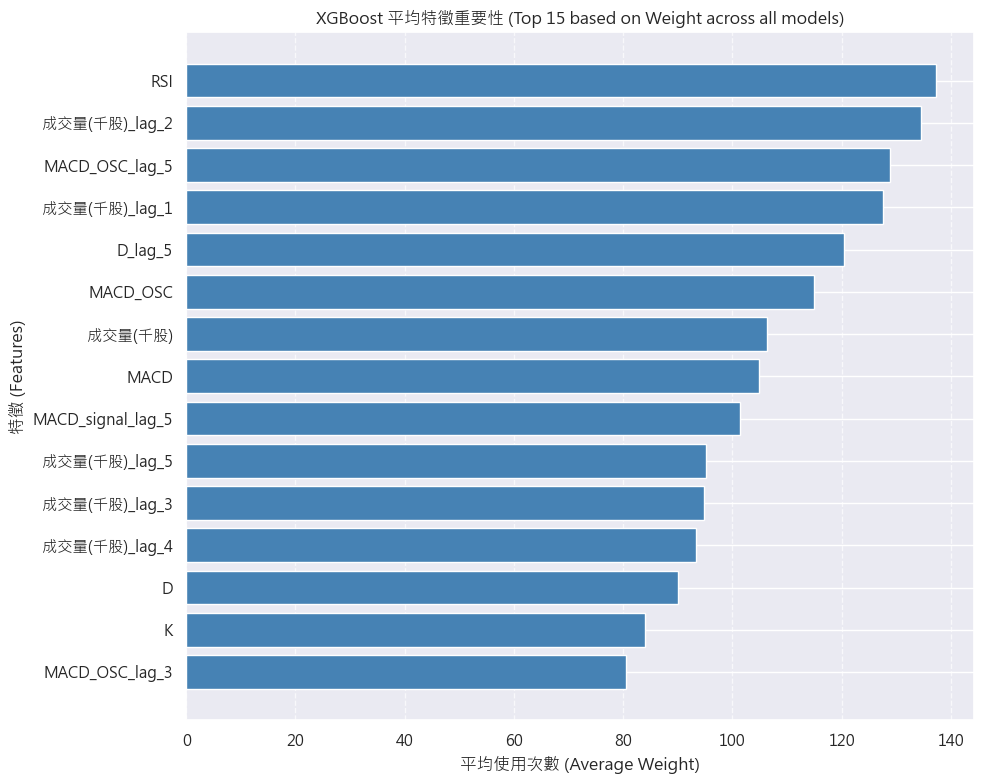

In [8]:
# Cell 6: 計算並繪製平均特徵重要性 (使用次數)

if 'all_feature_importances' in locals() and all_feature_importances:
    print(f"\n--- 計算並繪製 {len(all_feature_importances)} 個模型的平均特徵重要性 (Weight/使用次數) ---")

    # 1. 將分數列表轉換為 DataFrame
    #    每一列代表一個特徵，每一行代表一次訓練的重要性分數
    #    缺失值 (某次訓練中未使用到的特徵) 填 0
    df_importances = pd.DataFrame(all_feature_importances).fillna(0)

    # 2. 計算每個特徵的平均重要性分數
    average_importance = df_importances.mean().sort_values(ascending=False)

    # 3. 選取 Top N 特徵進行繪製 (例如 Top 15)
    top_n = 15
    top_features = average_importance.head(top_n)

    # 4. 使用 Matplotlib 繪製水平條形圖
    plt.figure(figsize=(10, 8)) # 調整圖大小以便容納更多特徵
    plt.barh(top_features.index[::-1], top_features.values[::-1], color='steelblue') # [::-1] 反轉順序，讓最重要的在最上面
    plt.xlabel("平均使用次數 (Average Weight)")
    plt.ylabel("特徵 (Features)")
    plt.title(f"XGBoost 平均特徵重要性 (Top {top_n} based on Weight across all models)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # --- 儲存圖檔 ---
    filename = "average_feature_importance_weight.png" # 改了檔名以區分
    save_path = OUTDIR / filename
    try:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"平均特徵重要性圖已儲存至: {save_path}")
    except Exception as e:
        print(f"錯誤：儲存圖檔 '{save_path}' 失敗: {e}")

    plt.show()
    plt.close()

    # (可選) 打印所有特徵的平均重要性分數
    # print("\n--- 所有特徵的平均重要性分數 (Weight) ---")
    # print(average_importance.to_string())

elif 'all_feature_importances' not in locals():
     print("錯誤: 'all_feature_importances' 列表未定義 (Cell 5 未正確執行?)，無法計算平均重要性。")
elif not all_feature_importances:
     print("記錄到的特徵重要性分數列表為空，無法計算平均重要性。可能沒有模型被重新訓練。")


--- ML 模型分類報告 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       323
           1       0.35      0.11      0.17       105
           2       0.14      0.12      0.13        49

    accuracy                           0.61       477
   macro avg       0.39      0.36      0.35       477
weighted avg       0.56      0.61      0.57       477



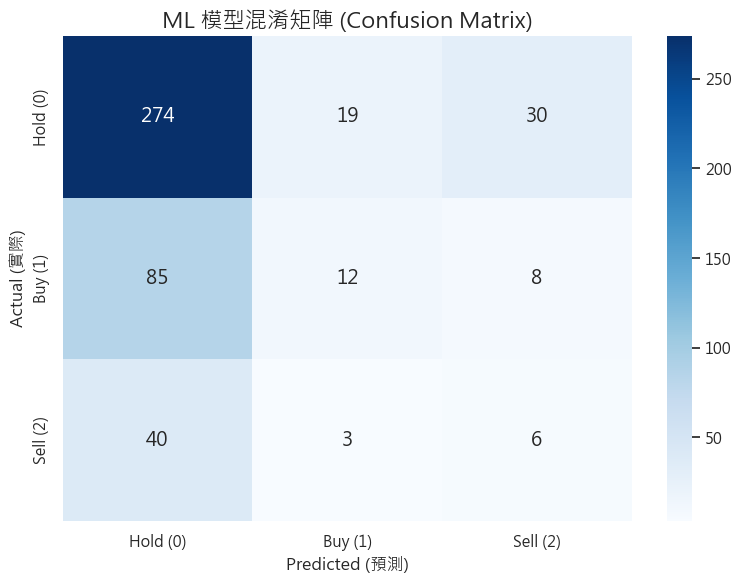

In [9]:
# Cell 7: 分類報告與混淆矩陣 
if len(y_true_all) > 0 and len(y_pred_all) > 0:
    print("\n--- ML 模型分類報告 ---")
    print("Classification Report:")
    print(classification_report(y_true_all, y_pred_all))

    # 計算混淆矩陣
    cm = confusion_matrix(y_true_all, y_pred_all)

    # 繪製混淆矩陣熱圖
    plt.figure(figsize=(8, 6))
    labels = ['Hold (0)', 'Buy (1)','Sell (2)'] 
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                annot_kws={"size": 14})
    plt.title('ML 模型混淆矩陣 (Confusion Matrix)', fontsize=16)
    plt.ylabel('Actual (實際)', fontsize=12)
    plt.xlabel('Predicted (預測)', fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTDIR / "confusion_matrix_ml.png", dpi=150)
    plt.show()
    plt.close()
else:
    print("沒有 ML 預測結果可供評估，跳過分類報告與混淆矩陣。")

In [10]:
# Cell 8: 建立包含所有訊號的回測資料 df_test 

if len(test_indices) > 0 and 'data_ml' in locals(): # 確保有預測索引和原始數據
    print("\n--- 準備回測資料 df_test (包含所有策略訊號) ---")

    # 1. 取得 ML 模型的預測訊號
    df_results_ml = pd.DataFrame({
        'Predicted_Signal': y_pred_all # 這是 ML 模型的預測 (0, 1, 2)
    }, index=test_indices) # 使用模型測試的日期作為索引

    # 2. 從 data_final (包含非延遲特徵) 中，根據相同的日期索引，取出價格資料和技術指標訊號
    #    因為 test_indices 是從 X 來的 (X 是 data_final drop 某些欄位後的結果)，索引應該能對上
    try:
        # 價格
        df_prices = data_final.loc[test_indices, ['開盤價(元)', '收盤價(元)']]
        # 技術指標訊號 (已經是 0, 1, 2)
        df_signals_ti = data_final.loc[test_indices, ['signal_RSI', 'signal_MACD', 'signal_KD']]

        # 3. 將 價格、ML訊號、TI訊號 組合起來
        df_test = pd.concat([df_prices, df_results_ml, df_signals_ti], axis=1)

        # 確保 Index 是 DatetimeIndex
        df_test.index = pd.to_datetime(df_test.index)

        print("df_test 建立完成，包含價格與所有策略訊號")
        print(df_test.head())
        print("\n--- df_test 欄位資訊 ---")
        print(df_test.info())
        print("\n--- df_test 缺失值檢查 ---")
        print(df_test.isna().sum())


    except KeyError as e:
        print(f"錯誤：無法從 'data_final' 中找到 {e} 欄位。")
        print("請確認 data_final 中是否包含 '開盤價(元)', '收盤價(元)', 'signal_RSI', 'signal_MACD', 'signal_KD' 欄位。")
        df_test = pd.DataFrame() # 建立失敗，設為空
    except Exception as e:
        print(f"建立 df_test 時發生預期外的錯誤: {e}")
        df_test = pd.DataFrame() # 建立失敗，設為空
else:
    print("沒有 ML 預測結果或 data_ml 不存在，無法建立 df_test。")
    df_test = pd.DataFrame() # 建立失敗，設為空


--- 準備回測資料 df_test (包含所有策略訊號) ---
df_test 建立完成，包含價格與所有策略訊號
             開盤價(元)   收盤價(元)  Predicted_Signal  signal_RSI  signal_MACD  \
2019-01-02  9725.27  9554.14                 0           0            0   
2019-01-03  9494.25  9492.42                 0           0            0   
2019-01-04  9427.24  9382.51                 0           0            0   
2019-01-07  9460.20  9590.30                 0           0            0   
2019-01-08  9591.56  9563.60                 0           0            0   

            signal_KD  
2019-01-02          0  
2019-01-03          0  
2019-01-04          0  
2019-01-07          0  
2019-01-08          0  

--- df_test 欄位資訊 ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 477 entries, 2019-01-02 to 2020-12-17
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   開盤價(元)            477 non-null    float64
 1   收盤價(元)            477 non-null    float64
 2   Predict

In [11]:
# Cell 9: 回測函數定義與參數設定 

# ========== 回測函數 (T+1 開盤價成交) ==========
def backtest_t1_open_in_chunks(
    df_input, # 包含 Date, Open, Close 欄位的 DataFrame
    signal_series, # 單獨的訊號 Series (index 需與 df_input 一致, 值為 0, 1, 2)
    strategy_name, # 策略名稱，用於輸出欄位
    init_capital=1_000_000,
    init_invest_ratio=0.80,
    step_amount=100_000,
    cash_rate_annual=0.01,
):
    """
    針對單一策略訊號進行回測。
    訊號值: 1=買, 2=賣, 0=持有
    返回: 包含資產淨值曲線的 Series
    """
    if df_input.empty or signal_series.empty:
        print(f"輸入資料或訊號為空，無法為 {strategy_name} 執行回測。")
        return pd.Series(name=f"Portfolio_{strategy_name}", dtype=float)

    print(f"\n--- 開始執行策略 '{strategy_name}' 的回測 ---")

    # 準備價格和訊號數據
    date_s  = pd.to_datetime(df_input.index) # 直接用 index
    open_s  = pd.to_numeric(df_input['開盤價(元)'], errors='coerce').astype(float)
    close_s = pd.to_numeric(df_input['收盤價(元)'], errors='coerce').astype(float)

    # 將訊號值 (1=買, 2=賣, 0=持有) 轉換為 (1=買, -1=賣, 0=持有)
    # 並應用 shift(1) 使其在 T+1 生效
    sig_s = signal_series.fillna(0).astype(int).replace(2, -1)
    eff_sig = sig_s.shift(1).fillna(0).astype(int)

    # 日曆天數差異 (用於計息)
    day_diff = date_s.to_series().diff().dt.days.fillna(1).astype(int).values
    daily_rate = cash_rate_annual / 365.0

    portfolio_values = []
    cash = float(init_capital)
    shares = 0

    # 初始股數 (第一天開盤買入 80%)
    first_open_price = open_s.iloc[0]
    if pd.notna(first_open_price) and first_open_price > 0:
        init_budget = init_capital * float(init_invest_ratio)
        first_shares = int(init_budget // first_open_price)
        spend = first_shares * first_open_price
        shares += first_shares
        cash -= spend
        print(f"初始買入: 價格 {first_open_price:.2f}, 股數 {first_shares}, 花費 {spend:.2f}, 剩餘現金 {cash:.2f}")
    else:
        print("警告：第一筆開盤價無效，無法執行初始買入。")
        # 如果無法初始買入，後續回測可能無意義，但還是繼續計算現金利息

    # 回測循環 (T+1 開盤交易, T+1 收盤估值)
    for i in range(len(df_input)):
        current_date = date_s[i]
        trade_executed = False
        trade_type = "None"
        trade_shares = 0
        trade_price = np.nan

        # 1) 根據「昨日訊號」(eff_sig) 於今日開盤執行加/減碼
        current_open_price = open_s.iloc[i]
        if pd.notna(current_open_price) and current_open_price > 0:
            px = current_open_price
            signal_today = eff_sig.iloc[i] # T+1 生效的訊號

            if signal_today == 1: # 買進訊號
                buy_shares_intended = int(step_amount // px)
                buy_shares_possible = int(cash // px)
                buy_shares = min(buy_shares_intended, buy_shares_possible)

                if buy_shares > 0:
                    cost = buy_shares * px
                    cash -= cost
                    shares += buy_shares
                    trade_executed = True
                    trade_type = "Buy"
                    trade_shares = buy_shares
                    trade_price = px
                    # print(f"{current_date.date()} Buy Signal: Price={px:.2f}, Buy Shares={buy_shares}, Cost={cost:.2f}, Cash={cash:.2f}, Total Shares={shares}")


            elif signal_today == -1: # 賣出訊號
                sell_shares_intended = int(step_amount // px)
                if sell_shares_intended > 0 and shares > 0:
                    qty_to_sell = min(shares, sell_shares_intended)
                    proceeds = qty_to_sell * px
                    cash += proceeds
                    shares -= qty_to_sell
                    trade_executed = True
                    trade_type = "Sell"
                    trade_shares = qty_to_sell
                    trade_price = px
                    # print(f"{current_date.date()} Sell Signal: Price={px:.2f}, Sell Shares={qty_to_sell}, Proceeds={proceeds:.2f}, Cash={cash:.2f}, Total Shares={shares}")

        # 2) 閒置現金計息 (依日曆天)
        days = max(1, int(day_diff[i]))
        
        if cash > 0:
             cash *= (1.0 + daily_rate) ** days

        # 3) T+1 收盤估值
        current_close_price = close_s.iloc[i]
        stock_value = 0
        total_value = cash # 預設值為現金

        if pd.isna(current_close_price):
            if i > 0:
                # 如果收盤價缺失，沿用上一天的總價值
                total_value = portfolio_values[-1]
                stock_value = total_value - cash # 反推股票價值
                print(f"警告: {current_date.date()} 收盤價缺失，沿用前一天總價值 {total_value:.2f}")
            else:
                # 第一天就缺失，總價值只有現金
                print(f"警告: {current_date.date()} 第一天收盤價缺失，總價值僅計現金 {total_value:.2f}")
        else:
            stock_value = shares * current_close_price
            total_value = cash + stock_value

        portfolio_values.append(total_value)

        # (可選) 打印每日詳細信息，用於調試
        # print(f"{current_date.date()} | Signal(T): {sig_s.iloc[i-1] if i>0 else 0} | EffSignal(T+1): {eff_sig.iloc[i]} | Trade: {trade_type}({trade_shares}@{trade_price:.2f}) | Interest: {interest:.2f} | Cash: {cash:.2f} | Shares: {shares} | Close: {current_close_price:.2f} | StockVal: {stock_value:.2f} | Total: {total_value:.2f}")


    print(f"--- 策略 '{strategy_name}' 回測完成 ---")
    return pd.Series(portfolio_values, index=df_input.index, name=f"Portfolio_{strategy_name}")


# ====== 回測參數設定 ======
initial_capital = 1_000_000
init_invest_ratio = 0.80     # 初始 80% 進場
step_amount = 100_000        # 每次買/賣 10 萬元
cash_rate_annual = 0.01      # 現金年利 1%

In [12]:
# Cell 10: 【【【新增】】】執行所有策略的回測並儲存結果

if not df_test.empty: # 確保 df_test 已成功建立
    print("\n--- 開始執行所有策略的回測 ---")

    # === 策略訊號欄位名稱映射 ===
    strategy_signals = {
        "ML": "Predicted_Signal",
        "RSI": "signal_RSI",
        "MACD": "signal_MACD",
        "KD": "signal_KD"
    }

    portfolio_results = {} # 用於儲存每個策略的資產曲線 Series

    # --- 執行機器學習與技術指標策略回測 ---
    for name, signal_col in strategy_signals.items():
        if signal_col in df_test.columns:
            portfolio_series = backtest_t1_open_in_chunks(
                df_test, # 包含 Open, Close 的 DataFrame (索引為日期)
                df_test[signal_col], # 該策略的訊號 Series
                strategy_name=name,
                init_capital=initial_capital,
                init_invest_ratio=init_invest_ratio,
                step_amount=step_amount,
                cash_rate_annual=cash_rate_annual
            )
            portfolio_results[name] = portfolio_series
        else:
            print(f"警告：在 df_test 中找不到訊號欄位 '{signal_col}'，無法執行策略 '{name}' 的回測。")

    # --- 計算買入持有基準 (B&H) ---
    print("\n--- 計算買入持有 (B&H) 基準 ---")
    # 使用與回測函數類似的邏輯計算 B&H，確保一致性
    open_s  = pd.to_numeric(df_test['開盤價(元)'], errors='coerce').astype(float)
    close_s = pd.to_numeric(df_test['收盤價(元)'], errors='coerce').astype(float)
    date_s = pd.to_datetime(df_test.index)
    day_diff = date_s.to_series().diff().dt.days.fillna(1).astype(int).values
    daily_rate = cash_rate_annual / 365.0

    bh_shares = 0
    bh_cash = float(initial_capital)
    first_open = open_s.iloc[0]

    if pd.notna(first_open) and first_open > 0:
        # B&H 初始投入全部資金 (或 100%)
        bh_shares = int(initial_capital // first_open)
        bh_cash = initial_capital - bh_shares * first_open
        print(f"B&H 初始買入: 價格 {first_open:.2f}, 股數 {bh_shares}, 花費 {bh_shares * first_open:.2f}, 剩餘現金 {bh_cash:.2f}")

    bh_values = []
    for i in range(len(df_test)):
        days = max(1, int(day_diff[i]))
        if bh_cash > 0:
            bh_cash *= (1.0 + daily_rate) ** days # 現金計息

        current_close = close_s.iloc[i]
        total_value = bh_cash # 預設值
        if pd.isna(current_close):
            total_value = bh_values[-1] if i > 0 else bh_cash
        else:
            total_value = bh_cash + bh_shares * current_close

        bh_values.append(total_value)

    portfolio_results["BH"] = pd.Series(bh_values, index=df_test.index, name="Portfolio_BH")
    print("--- B&H 計算完成 ---")

    # --- 將所有回測結果加入 df_test ---
    print("\n--- 將回測結果加入 df_test ---")
    for name, series in portfolio_results.items():
        if not series.empty:
            portfolio_col = f"Portfolio_{name}"
            cum_return_col = f"Cumulative_Return_{name}"
            daily_return_col = f"Daily_Return_{name}"

            df_test[portfolio_col] = series
            # 計算日報酬率
            df_test[daily_return_col] = df_test[portfolio_col].pct_change().fillna(0)
            # 計算累積報酬率 (相對於初始資金)
            df_test[cum_return_col] = df_test[portfolio_col] / initial_capital
            print(f"已加入欄位: {portfolio_col}, {daily_return_col}, {cum_return_col}")

    print("\n--- df_test 更新完成，包含所有策略的資產淨值與報酬率 ---")
    print(df_test.head())
    # 檢查是否有任何 Portfolio 計算失敗 (全為 NaN)
    for name in strategy_signals.keys():
        col_name = f"Portfolio_{name}"
        if col_name in df_test and df_test[col_name].isnull().all():
            print(f"警告：策略 '{name}' 的資產曲線 ({col_name}) 計算失敗或全為 NaN。")
    if 'Portfolio_BH' in df_test and df_test['Portfolio_BH'].isnull().all():
         print(f"警告：買入持有基準 (Portfolio_BH) 計算失敗或全為 NaN。")

else:
    print("df_test 為空，跳過所有回測執行。")


--- 開始執行所有策略的回測 ---

--- 開始執行策略 'ML' 的回測 ---
初始買入: 價格 9725.27, 股數 82, 花費 797472.14, 剩餘現金 202527.86
--- 策略 'ML' 回測完成 ---

--- 開始執行策略 'RSI' 的回測 ---
初始買入: 價格 9725.27, 股數 82, 花費 797472.14, 剩餘現金 202527.86
--- 策略 'RSI' 回測完成 ---

--- 開始執行策略 'MACD' 的回測 ---
初始買入: 價格 9725.27, 股數 82, 花費 797472.14, 剩餘現金 202527.86
--- 策略 'MACD' 回測完成 ---

--- 開始執行策略 'KD' 的回測 ---
初始買入: 價格 9725.27, 股數 82, 花費 797472.14, 剩餘現金 202527.86
--- 策略 'KD' 回測完成 ---

--- 計算買入持有 (B&H) 基準 ---
B&H 初始買入: 價格 9725.27, 股數 102, 花費 991977.54, 剩餘現金 8022.46
--- B&H 計算完成 ---

--- 將回測結果加入 df_test ---
已加入欄位: Portfolio_ML, Daily_Return_ML, Cumulative_Return_ML
已加入欄位: Portfolio_RSI, Daily_Return_RSI, Cumulative_Return_RSI
已加入欄位: Portfolio_MACD, Daily_Return_MACD, Cumulative_Return_MACD
已加入欄位: Portfolio_KD, Daily_Return_KD, Cumulative_Return_KD
已加入欄位: Portfolio_BH, Daily_Return_BH, Cumulative_Return_BH

--- df_test 更新完成，包含所有策略的資產淨值與報酬率 ---
             開盤價(元)   收盤價(元)  Predicted_Signal  signal_RSI  signal_MACD  \
2019-01-02  9725.27  9554.14    


--- 繪製累積報酬率比較圖 ---
累積報酬比較圖已儲存至 backtest_plots\20251029_210127\equity_compare_all_strategies.png


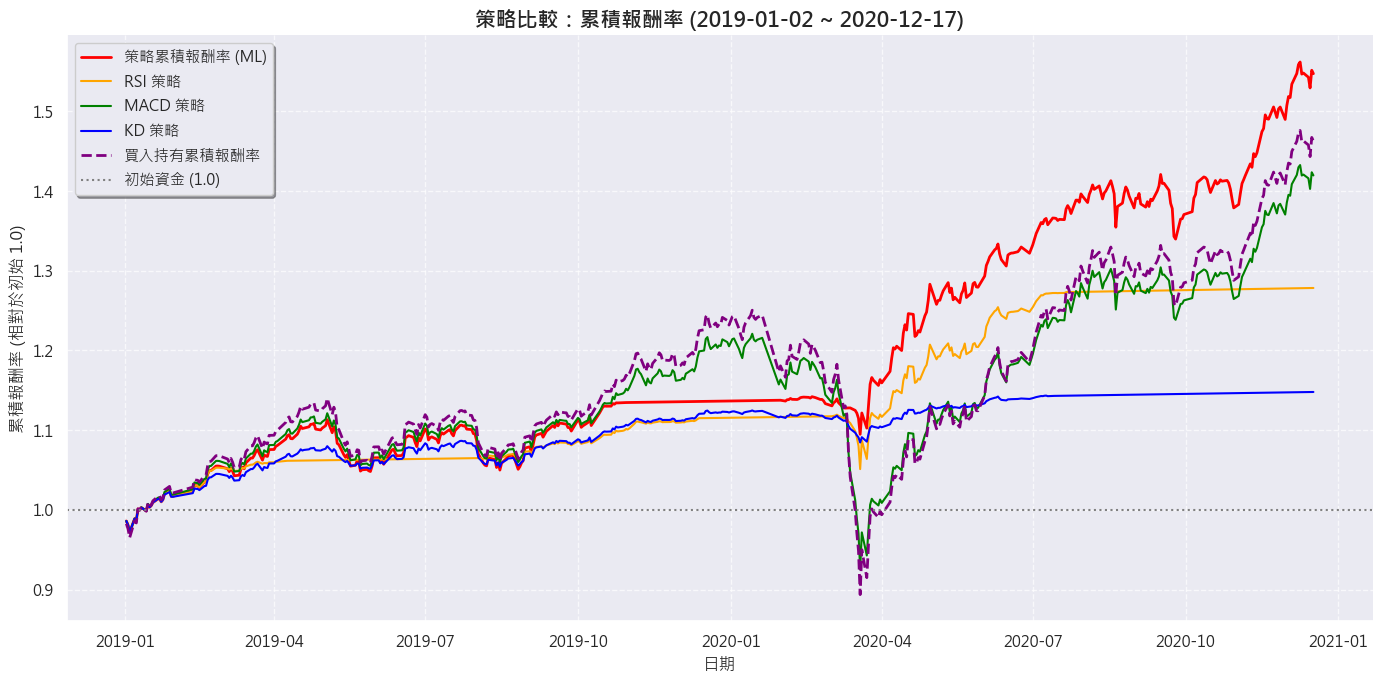


--- 所有策略的最終累積報酬率 ---
策略累積報酬率 (ML)        :   1.5472
RSI 策略              :   1.2783
MACD 策略             :   1.4196
KD 策略               :   1.1479
買入持有累積報酬率           :   1.4626


In [13]:
# Cell 11: 繪製所有策略的累積報酬率比較圖 

if not df_test.empty and not portfolio_results['ML'].isnull().all(): # 確保 df_test 和至少 ML 結果存在
    print("\n--- 繪製累積報酬率比較圖 ---")
    plt.figure(figsize=(14, 7))

    # === 繪製策略線 ===
    plot_map = {
        "ML": {"col": "Cumulative_Return_ML", "label": "策略累積報酬率 (ML)", "color": "red", "linewidth": 2.0},
        "RSI": {"col": "Cumulative_Return_RSI", "label": "RSI 策略", "color": "orange", "linewidth": 1.5},
        "MACD": {"col": "Cumulative_Return_MACD", "label": "MACD 策略", "color": "green", "linewidth": 1.5},
        "KD": {"col": "Cumulative_Return_KD", "label": "KD 策略", "color": "blue", "linewidth": 1.5},
        "BH": {"col": "Cumulative_Return_BH", "label": "買入持有累積報酬率", "color": "purple", "linestyle": '--', "linewidth": 2.0},
    }

    for name, settings in plot_map.items():
        col = settings["col"]
        if col in df_test.columns and not df_test[col].isnull().all():
            plt.plot(df_test.index, df_test[col],
                     label=settings["label"],
                     color=settings.get("color"),
                     linestyle=settings.get("linestyle", '-'),
                     linewidth=settings.get("linewidth", 1.0))
        else:
             print(f"警告：找不到或無法繪製策略 '{name}' 的累積報酬率 ({col})。")


    # 初始資金水平線
    plt.axhline(1, color='grey', linestyle=':', linewidth=1.5, label='初始資金 (1.0)')

    # 設定圖表標題和標籤
    start_dt_str = df_test.index.min().strftime('%Y-%m-%d')
    end_dt_str = df_test.index.max().strftime('%Y-%m-%d')
    plt.title(f"策略比較：累積報酬率 ({start_dt_str} ~ {end_dt_str})", fontsize=15, weight='bold')
    plt.xlabel("日期", fontsize=12)
    plt.ylabel("累積報酬率 (相對於初始 1.0)", fontsize=12)

    # 顯示圖例
    plt.legend(loc='best', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    sns.despine() # 移除上方和右方邊框
    plt.tight_layout() # 自動調整邊距

    # 儲存圖檔
    plt.savefig(OUTDIR / "equity_compare_all_strategies.png", dpi=200, bbox_inches="tight")
    print(f"累積報酬比較圖已儲存至 {OUTDIR / 'equity_compare_all_strategies.png'}")

    # 顯示圖表
    plt.show()
    plt.close()

else:
    print("df_test 為空或 ML 結果不存在，無法繪製累積報酬率比較圖。")
# --- 【新增】的代碼：顯示所有策略的最終累積報酬率 ---
print("\n--- 所有策略的最終累積報酬率 ---")
for name, settings in plot_map.items():
    col = settings["col"]
    if col in df_test.columns and not df_test[col].isnull().all():
        # 獲取最後一個非 NaN 值
        final_return = df_test[col].dropna().iloc[-1]
        print(f"{settings['label']:<20}: {final_return:>8.4f}")
    else:
        print(f"無法計算 '{name}' ({col}) 的最終報酬率。")
# --- 【新增】的代碼結束 ---




--- 繪製技術指標策略訊號圖 ---
RSI 策略訊號圖已儲存至 backtest_plots\20251029_210127\signals_RSI.png


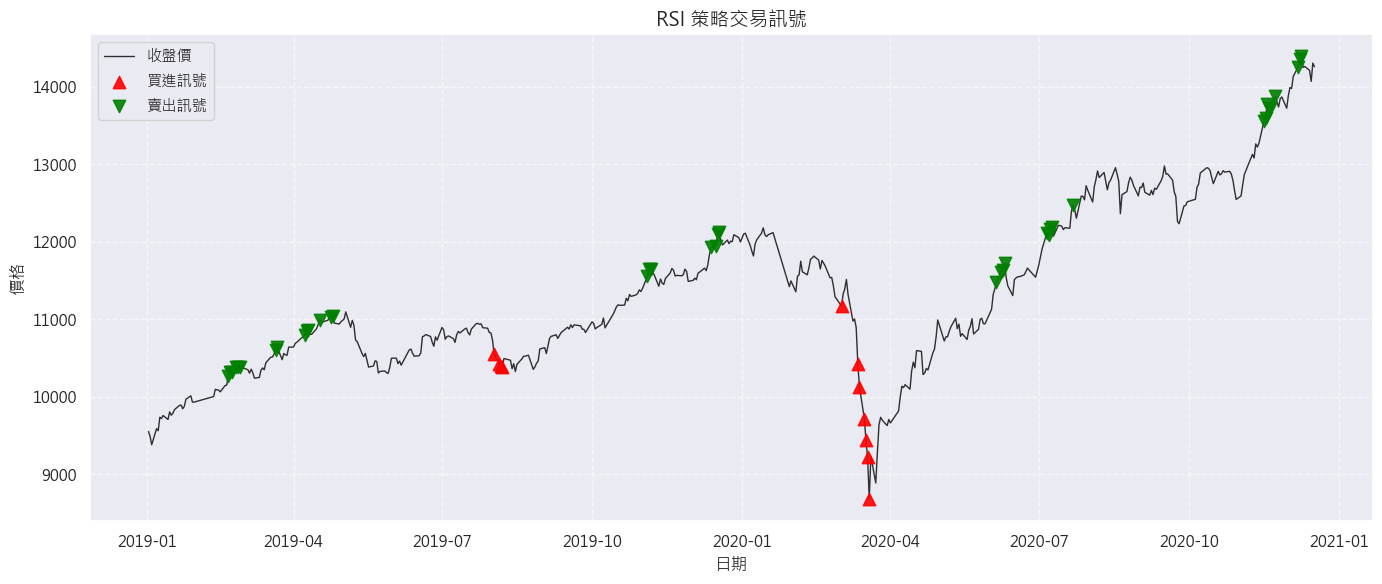

MACD 策略訊號圖已儲存至 backtest_plots\20251029_210127\signals_MACD.png


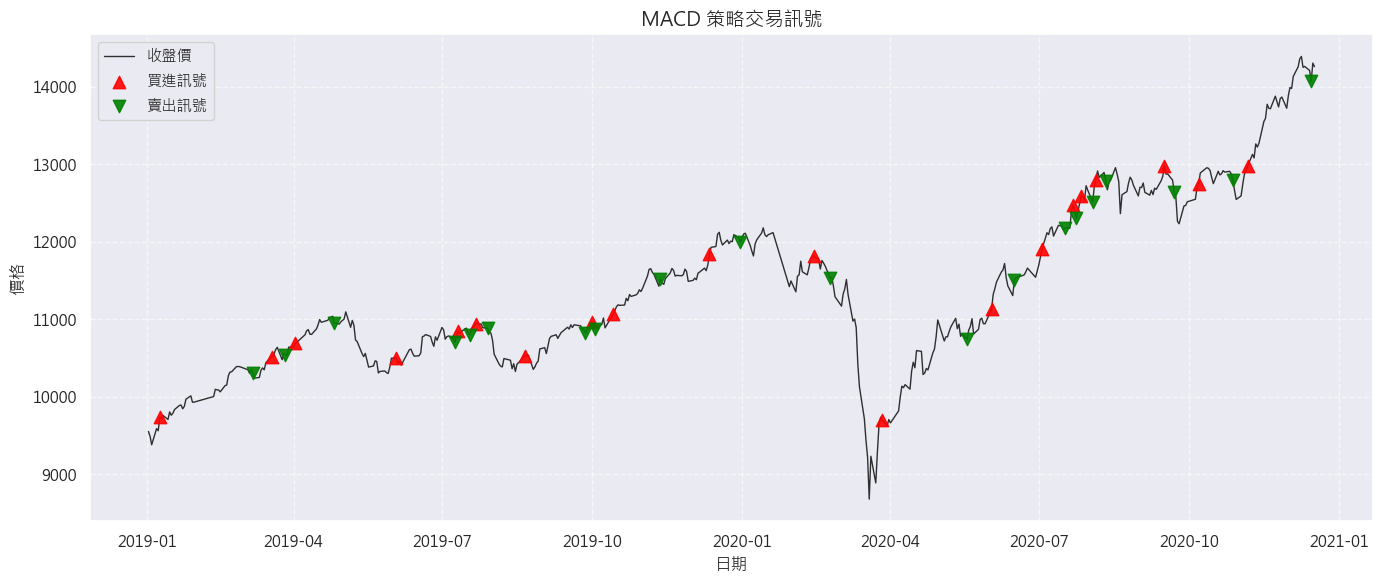

KD 策略訊號圖已儲存至 backtest_plots\20251029_210127\signals_KD.png


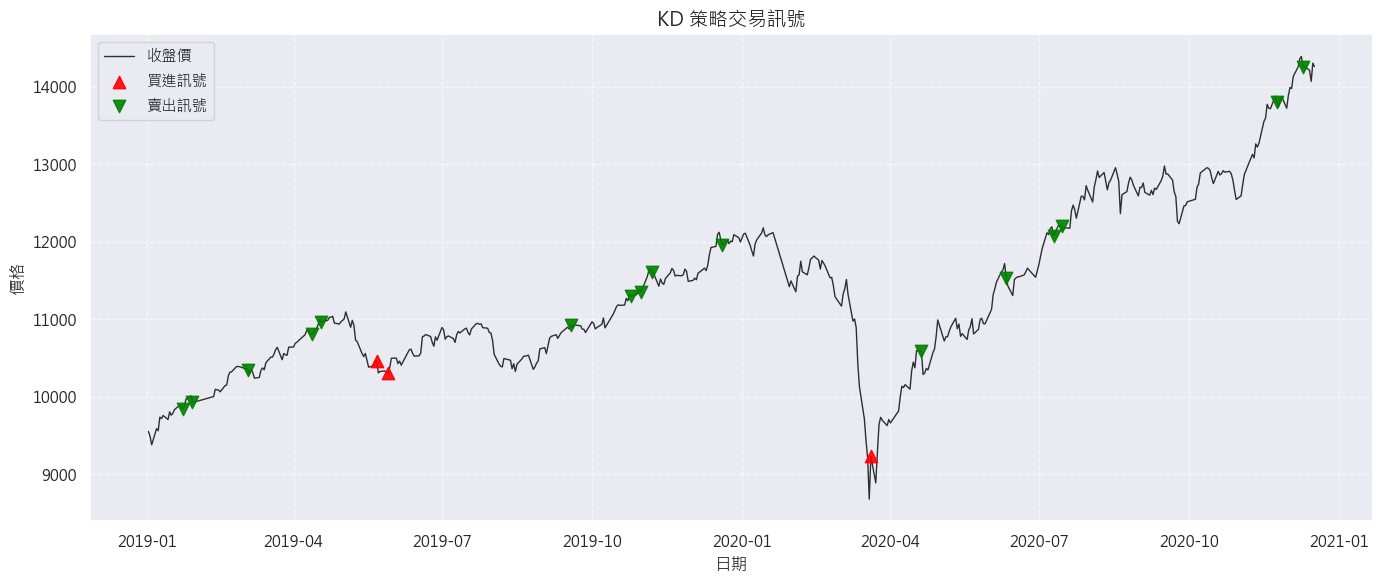


--- 繪製 ML 策略訊號圖 ---
ML 策略訊號圖已儲存至 backtest_plots\20251029_210127\signals_ML.png


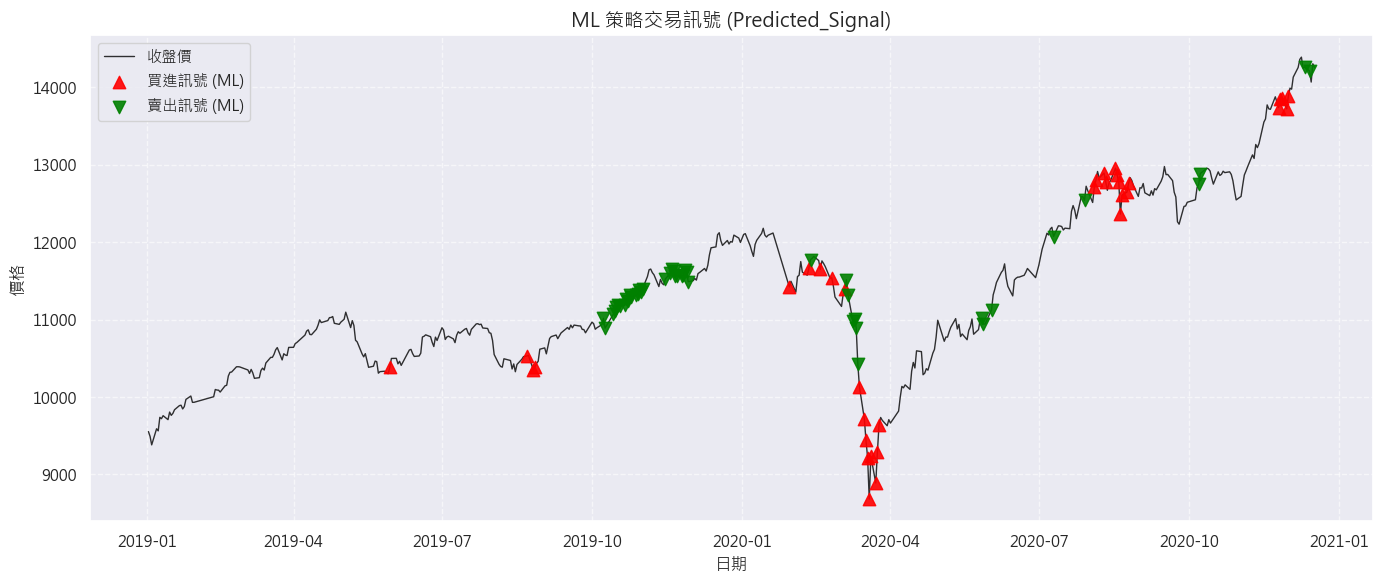

In [14]:
# Cell 12: 【繪製技術指標策略的買賣訊號圖

if not df_test.empty:
    print("\n--- 繪製技術指標策略訊號圖 ---")

    ti_signal_map = {
        "RSI": "signal_RSI",
        "MACD": "signal_MACD",
        "KD": "signal_KD"
    }

    for name, signal_col in ti_signal_map.items():
        if signal_col in df_test.columns:
            plt.figure(figsize=(14, 6))
            # 繪製收盤價
            plt.plot(df_test.index, df_test['收盤價(元)'], label="收盤價", color='black', linewidth=1, alpha=0.8)

            # 找出買賣點 (訊號為 1 或 2)
            buy_signals = df_test[df_test[signal_col] == 1]
            sell_signals = df_test[df_test[signal_col] == 2]

            # 繪製買點
            plt.scatter(buy_signals.index, buy_signals['收盤價(元)'],
                        marker='^', color='red', s=80, label='買進訊號', zorder=5, alpha=0.9)
            # 繪製賣點
            plt.scatter(sell_signals.index, sell_signals['收盤價(元)'],
                        marker='v', color='green', s=80, label='賣出訊號', zorder=5, alpha=0.9)

            # 設定圖表
            plt.title(f"{name} 策略交易訊號", fontsize=14)
            plt.xlabel("日期")
            plt.ylabel("價格")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()

            # 儲存圖檔
            filename = f"signals_{name}.png"
            plt.savefig(OUTDIR / filename, dpi=150, bbox_inches="tight")
            print(f"{name} 策略訊號圖已儲存至 {OUTDIR / filename}")

            plt.show()
            plt.close()
        else:
            print(f"警告：在 df_test 中找不到訊號欄位 '{signal_col}'，無法繪製 {name} 策略訊號圖。")
else:
    print("df_test 為空，跳過繪製技術指標訊號圖。")

# 繪製 ML 模型的訊號圖 (沿用您 Cell 8 的邏輯，稍作修改)
if not df_test.empty and 'Predicted_Signal' in df_test.columns:
    print("\n--- 繪製 ML 策略訊號圖 ---")
    plt.figure(figsize=(14,6))
    plt.plot(df_test.index, df_test['收盤價(元)'], label="收盤價", color='black', linewidth=1, alpha=0.8)
    # 買進訊號 (y_pred = 1)
    buy_signals_ml = df_test[df_test['Predicted_Signal'] == 1]
    plt.scatter(buy_signals_ml.index, buy_signals_ml['收盤價(元)'],
        marker='^', color='red', s=80, label='買進訊號 (ML)', zorder=5, alpha=0.9)
    # 賣出訊號 (y_pred = 2)
    sell_signals_ml = df_test[df_test['Predicted_Signal'] == 2]
    plt.scatter(sell_signals_ml.index, sell_signals_ml['收盤價(元)'],
        marker='v', color='green', s=80, label='賣出訊號 (ML)', zorder=5, alpha=0.9)

    plt.title("ML 策略交易訊號 (Predicted_Signal)", fontsize=14)
    plt.xlabel("日期")
    plt.ylabel("價格")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    filename = "signals_ML.png"
    plt.savefig(OUTDIR / filename, dpi=150, bbox_inches="tight")
    print(f"ML 策略訊號圖已儲存至 {OUTDIR / filename}")
    plt.show()
    plt.close()
else:
    print("df_test 為空或缺少 'Predicted_Signal'，跳過繪製 ML 策略訊號圖。")

In [15]:
# Cell 13: 計算並比較所有策略的績效指標 

# ========== 績效指標計算函數 ==========
def performance_metrics(daily_returns, rf_rate=0.01): # 直接傳入日報酬 Series
    """
    從日報酬率計算 Std Dev, Sharpe, Max Drawdown, Expected Value, Ann Vol.
    """
    results = {}
    N = 252 # 年化因子

    if daily_returns.empty or daily_returns.isnull().all():
        print("警告: 日報酬率數據為空或全為 NaN，無法計算績效指標。")
        metrics = {
            'Std Deviation (daily)': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan,
            'Expected Value': np.nan,
            'Annualized Volatility': np.nan
        }
        return pd.Series(metrics)


    # 1. 日頻標準差
    results['Std Deviation (daily)'] = daily_returns.std()

    # 2. 夏普比率（年化）
    mean_daily_return = daily_returns.mean()
    std_daily_return = daily_returns.std()
    if std_daily_return > 0:
         # 計算年化超額報酬
        annualized_excess_return = (mean_daily_return * N) - rf_rate
        # 計算年化波動率
        annualized_volatility = std_daily_return * np.sqrt(N)
        results['Sharpe Ratio'] = annualized_excess_return / annualized_volatility
    else:
        results['Sharpe Ratio'] = np.nan # 如果標準差為0 (例如報酬都一樣)，Sharpe 無意義

    # 3. 最大回撤（從日報酬計算累積報酬來找出最大回撤）
    cumulative_returns = (1 + daily_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    results['Max Drawdown'] = drawdown.min() if not drawdown.empty else np.nan

    # 4. 期望值（勝率 * 平均盈 - 負率 * 平均虧）
    wins = daily_returns[daily_returns > 0]
    losses = daily_returns[daily_returns <= 0] # <= 0 算虧損或持平
    total_trades = len(daily_returns)

    if total_trades > 0:
        win_rate = len(wins) / total_trades
        loss_rate = 1 - win_rate
        avg_win = wins.mean() if len(wins) > 0 else 0
        avg_loss = abs(losses.mean()) if len(losses) > 0 else 0 # 取絕對值
        results['Expected Value'] = win_rate * avg_win - loss_rate * avg_loss
    else:
        results['Expected Value'] = np.nan

    # 5. 年化波動率
    results['Annualized Volatility'] = std_daily_return * np.sqrt(N) if std_daily_return > 0 else np.nan

    return pd.Series(results)


# ===== 計算與比較所有策略績效 =====

if not df_test.empty:
    print("\n--- 計算所有策略的績效指標 ---")
    all_metrics = {}
    rf_rate = 0.01 # 無風險利率

    # 策略名稱與對應的日報酬欄位
    daily_return_cols = {
        "ML": "Daily_Return_ML",
        "RSI": "Daily_Return_RSI",
        "MACD": "Daily_Return_MACD",
        "KD": "Daily_Return_KD",
        "Buy & Hold": "Daily_Return_BH"
    }

    # 依序計算每個策略的指標
    for name, col in daily_return_cols.items():
        if col in df_test.columns and not df_test[col].isnull().all():
            print(f"計算策略 '{name}'...")
            daily_returns_series = df_test[col].dropna()
            # 確保有足夠數據點 (>1) 才能計算 std
            if len(daily_returns_series) > 1:
                 all_metrics[name] = performance_metrics(daily_returns_series, rf_rate)
            else:
                 print(f"警告：策略 '{name}' 的日報酬數據不足 (<2)，無法計算標準差相關指標。")
                 # 創建一個包含 NaN 的 Series
                 all_metrics[name] = pd.Series({
                    'Std Deviation (daily)': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan,
                    'Expected Value': daily_returns_series.mean() if len(daily_returns_series) > 0 else np.nan, # 期望值可能可以算平均
                    'Annualized Volatility': np.nan
                 })
        else:
            print(f"警告：找不到或 '{col}' 欄位全為 NaN，無法計算策略 '{name}' 的績效。")
            # 創建一個包含 NaN 的 Series
            all_metrics[name] = pd.Series({
                'Std Deviation (daily)': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan,
                'Expected Value': np.nan, 'Annualized Volatility': np.nan
            })

    # 合併成 DataFrame
    comparison_df = pd.DataFrame(all_metrics)

    # 調整順序
    desired_order = ["ML", "RSI", "MACD", "KD", "Buy & Hold"]
    # 過濾掉計算失敗的策略，只保留成功計算的策略來排序
    available_cols = [col for col in desired_order if col in comparison_df.columns]
    comparison_df = comparison_df[available_cols]


    # 輸出比較表格
    print("\n=== Performance Comparison ===")
    # 使用 .to_string() 控制格式，並處理 NaN
    print(comparison_df.to_string(float_format=lambda v: f"{v:.6f}" if pd.notna(v) else "NaN"))

    # (可選) 儲存成 CSV
    csv_path = OUTDIR / "performance_comparison.csv"
    try:
        comparison_df.to_csv(csv_path, encoding='utf_8_sig')
        print(f"\n績效比較表已儲存至 {csv_path}")
    except Exception as e:
        print(f"\n儲存績效比較表失敗: {e}")


else:
    print("df_test 為空，跳過績效指標計算。")


--- 計算所有策略的績效指標 ---
計算策略 'ML'...
計算策略 'RSI'...
計算策略 'MACD'...
計算策略 'KD'...
計算策略 'Buy & Hold'...

=== Performance Comparison ===
                             ML       RSI      MACD        KD  Buy & Hold
Std Deviation (daily)  0.006567  0.004076  0.009003  0.002675    0.010547
Sharpe Ratio           2.240704  1.998638  1.349429  1.676967    1.279958
Max Drawdown          -0.058401 -0.060968 -0.242168 -0.035776   -0.285362
Expected Value         0.000967  0.000553  0.000805  0.000322    0.000890
Annualized Volatility  0.104241  0.064699  0.142915  0.042472    0.167425

績效比較表已儲存至 backtest_plots\20251029_210127\performance_comparison.csv



--- 計算技術指標訊號正確率 ---
策略 signal_RSI: Buy(Correct/Total)=3/11, Sell(Correct/Total)=16/39, Overall(Correct/Total)=19/50
策略 signal_MACD: Buy(Correct/Total)=11/20, Sell(Correct/Total)=9/20, Overall(Correct/Total)=20/40
策略 signal_KD: Buy(Correct/Total)=1/3, Sell(Correct/Total)=7/16, Overall(Correct/Total)=8/19

--- 各技術指標策略訊號正確率 ---
             buy_accuracy  sell_accuracy  overall_accuracy
signal_RSI          0.273          0.410             0.380
signal_MACD         0.550          0.450             0.500
signal_KD           0.333          0.438             0.421

--- 繪製訊號正確率比較圖 ---
買/賣訊號正確率比較圖已儲存至 backtest_plots\20251029_210127\signal_buy_sell_accuracy.png


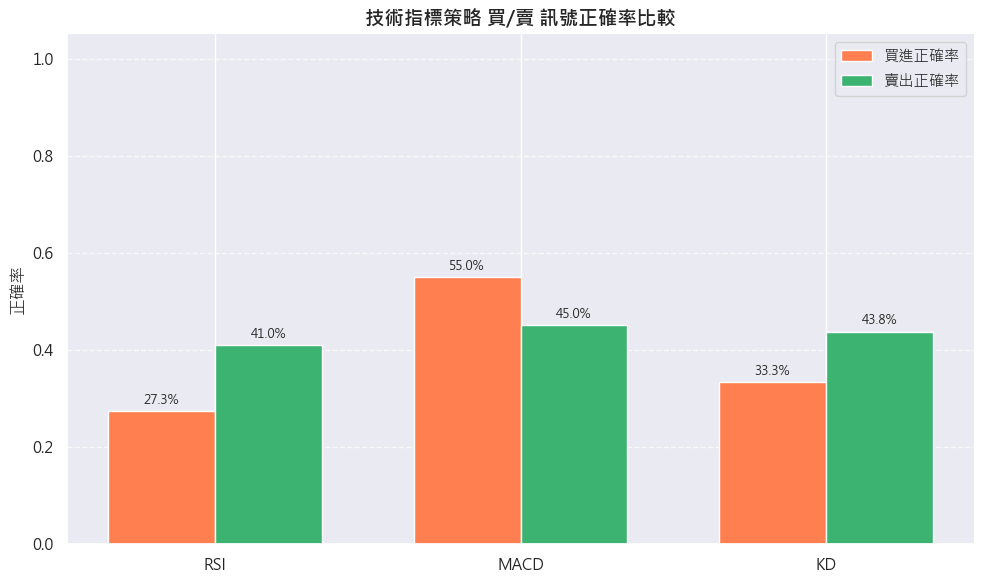

整體訊號正確率比較圖已儲存至 backtest_plots\20251029_210127\signal_overall_accuracy.png


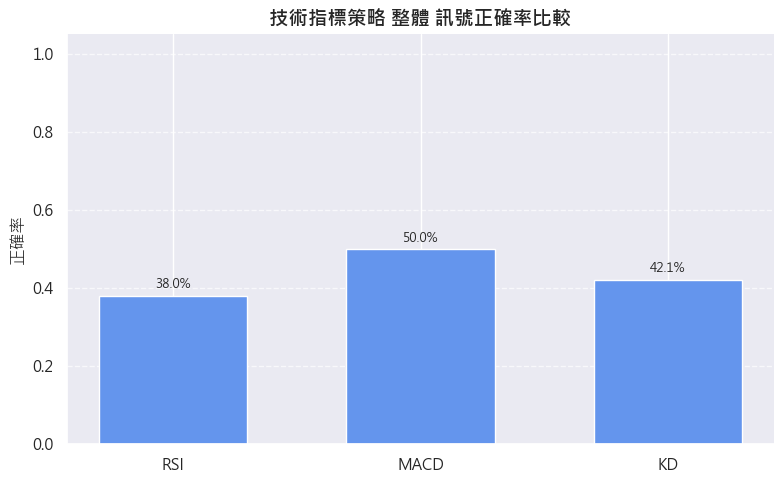

In [16]:
# Cell 14: 計算技術指標訊號正確率

if not df_test.empty:
    print("\n--- 計算技術指標訊號正確率 ---")

    # 計算下一期報酬率 (用於判斷訊號是否正確)
    # 使用測試集數據來計算，因為訊號是在測試集上評估的
    df_test['Future_Return'] = df_test['收盤價(元)'].pct_change().shift(-1)

    # 計算訊號正確率函數
    def signal_accuracy(df, signal_col, return_col='Future_Return'):
        """從 DataFrame 計算買/賣/整體訊號正確率"""
        if signal_col not in df.columns or return_col not in df.columns:
            print(f"警告: 缺少 '{signal_col}' 或 '{return_col}' 欄位，無法計算正確率。")
            return pd.Series({'buy_accuracy': np.nan, 'sell_accuracy': np.nan, 'overall_accuracy': np.nan}, name=signal_col)

        # 訊號 (1=Buy, 2=Sell, 0=Hold)
        buy_signals = df[df[signal_col] == 1]
        sell_signals = df[df[signal_col] == 2]

        # 計算買進訊號正確率 (下一期報酬 > 0)
        buy_correct = (buy_signals[return_col] > 0).sum()
        buy_total = len(buy_signals)
        buy_acc = buy_correct / buy_total if buy_total > 0 else np.nan

        # 計算賣出訊號正確率 (下一期報酬 < 0)
        sell_correct = (sell_signals[return_col] < 0).sum()
        sell_total = len(sell_signals)
        sell_acc = sell_correct / sell_total if sell_total > 0 else np.nan

        # 計算整體訊號正確率 (只考慮有買賣訊號的部分)
        overall_total = buy_total + sell_total
        overall_correct = buy_correct + sell_correct
        overall_acc = overall_correct / overall_total if overall_total > 0 else np.nan

        print(f"策略 {signal_col}: Buy(Correct/Total)={buy_correct}/{buy_total}, Sell(Correct/Total)={sell_correct}/{sell_total}, Overall(Correct/Total)={overall_correct}/{overall_total}")

        return pd.Series({'buy_accuracy': buy_acc, 'sell_accuracy': sell_acc, 'overall_accuracy': overall_acc}, name=signal_col)

    # 計算各技術指標策略正確率
    ti_signal_cols = ['signal_RSI', 'signal_MACD', 'signal_KD']
    acc_results = {}
    for col in ti_signal_cols:
        if col in df_test.columns:
            acc_results[col] = signal_accuracy(df_test, col)
        else:
            print(f"警告: df_test 中缺少 '{col}' 欄位，無法計算其正確率。")

    if acc_results: # 如果有計算出結果
        acc_table = pd.DataFrame(acc_results).T

        print("\n--- 各技術指標策略訊號正確率 ---")
        print(acc_table.to_string(float_format=lambda v: f"{v:.3f}" if pd.notna(v) else "NaN"))

        # --- 繪製長條圖 ---
        print("\n--- 繪製訊號正確率比較圖 ---")
        
        strategies_acc = acc_table.index.tolist()
        # 清理策略名稱中的 'signal_' 前綴以獲得更簡潔的標籤
        xtick_labels = [s.replace('signal_', '') for s in strategies_acc]
        x = np.arange(len(strategies_acc))

        buy_acc_vals = acc_table['buy_accuracy'].fillna(0).values # NaN 填 0 避免繪圖錯誤
        sell_acc_vals = acc_table['sell_accuracy'].fillna(0).values
        overall_acc_vals = acc_table['overall_accuracy'].fillna(0).values

        # 在 bar 上標註數值
        def autolabel(rects, ax):
            """在每個 bar 上方加上百分比標籤"""
            for rect in rects:
                height = rect.get_height()
                if pd.notna(height): # 只標註非 NaN 的值
                    ax.annotate(f'{height*100:.1f}%',
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # 垂直偏移 3 points
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=9)

        # --- 圖 1: 買/賣 訊號正確率 ---
        width_bs = 0.35 # 買/賣 條形寬度
        fig1, ax1 = plt.subplots(figsize=(10, 6))
        
        rects1 = ax1.bar(x - width_bs/2, buy_acc_vals, width_bs, label='買進正確率', color='coral')
        rects2 = ax1.bar(x + width_bs/2, sell_acc_vals, width_bs, label='賣出正確率', color='mediumseagreen')

        autolabel(rects1, ax1)
        autolabel(rects2, ax1)

        ax1.set_ylabel('正確率', fontsize=12)
        ax1.set_title('技術指標策略 買/賣 訊號正確率比較', fontsize=14, weight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(xtick_labels, fontsize=11)
        ax1.set_ylim(0, 1.05) # Y 軸上限設為 105% 以容納標籤
        ax1.legend(frameon=True)
        ax1.grid(axis='y', linestyle='--', alpha=0.7)
        sns.despine(fig=fig1) # 移除上方和右方邊框
        plt.tight_layout()

        # 儲存圖檔
        filename1 = "signal_buy_sell_accuracy.png"
        plt.savefig(OUTDIR / filename1, dpi=150, bbox_inches="tight")
        print(f"買/賣訊號正確率比較圖已儲存至 {OUTDIR / filename1}")
        
        plt.show() # 【【【修正】】】顯示圖 1
        plt.close(fig1) # 關閉圖 1

        # --- 圖 2: 整體訊號正確率 ---
        width_o = 0.6 # 整體 條形寬度
        fig2, ax2 = plt.subplots(figsize=(8, 5)) # 可以用稍小的圖

        rects3 = ax2.bar(x, overall_acc_vals, width_o, label='整體正確率', color='cornflowerblue')

        autolabel(rects3, ax2)

        ax2.set_ylabel('正確率', fontsize=12)
        ax2.set_title('技術指標策略 整體 訊號正確率比較', fontsize=14, weight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(xtick_labels, fontsize=11)
        ax2.set_ylim(0, 1.05)
        # ax2.legend(frameon=True) # 只有一種類別，legend 可選
        ax2.grid(axis='y', linestyle='--', alpha=0.7)
        sns.despine(fig=fig2)
        plt.tight_layout()

        # 儲存圖檔
        filename2 = "signal_overall_accuracy.png"
        plt.savefig(OUTDIR / filename2, dpi=150, bbox_inches="tight")
        print(f"整體訊號正確率比較圖已儲存至 {OUTDIR / filename2}")
        
        plt.show() # 【【【修正】】】顯示圖 2
        plt.close(fig2) # 關閉圖 2

    else:
        print("沒有計算出任何策略的正確率，跳過繪圖。")

else:
    print("df_test 為空，跳過訊號正確率計算與繪圖。")


--- 繪製 ML vs B&H 累積報酬率比較圖 ---
ML vs B&H 比較圖已儲存至: backtest_plots\20251029_210127\equity_compare_ML_BH.png


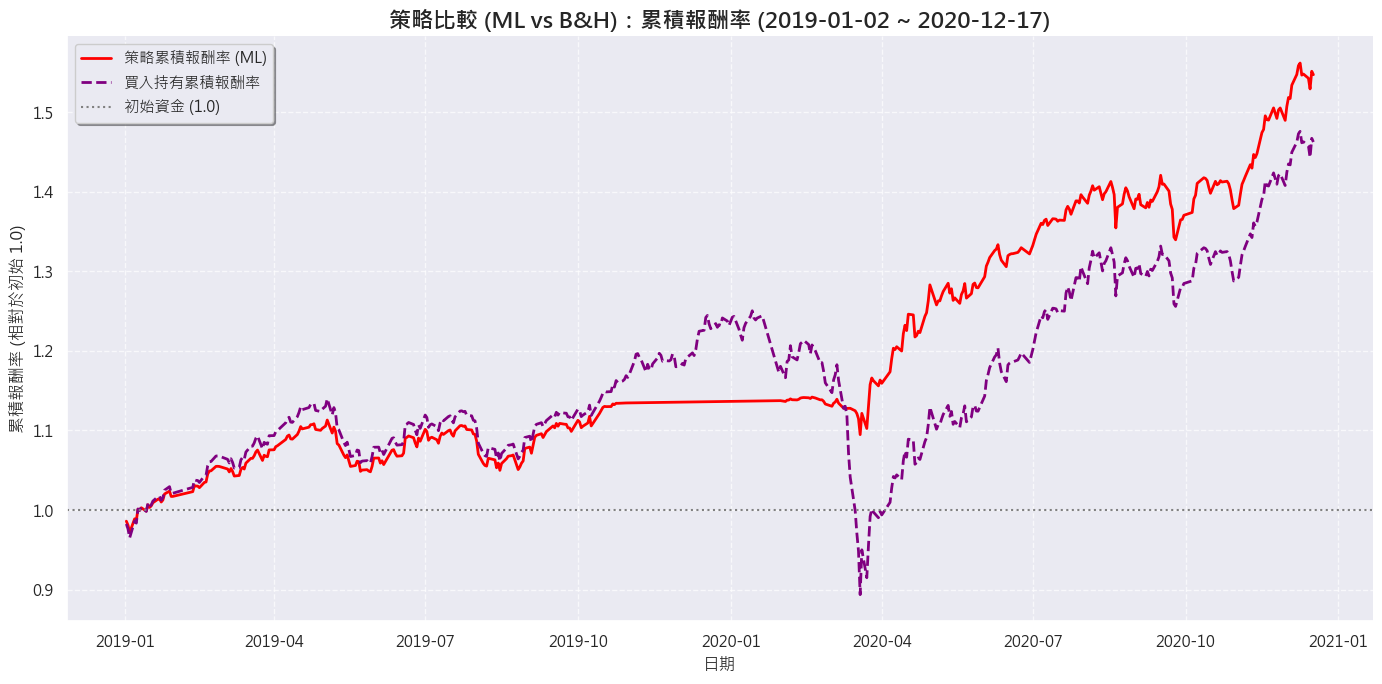


--- 最終累積報酬率 (相對於初始資金 1.0) ---
機器學習 (ML) 策略: 1.5472
買入持有 (B&H)  : 1.4626


In [17]:
# Cell 15: 繪製 ML vs B&H 累積報酬率比較圖

# 確保 df_test 存在且包含必要的欄位
if (not df_test.empty
    and 'Cumulative_Return_ML' in df_test.columns
    and 'Cumulative_Return_BH' in df_test.columns
    and not df_test['Cumulative_Return_ML'].isnull().all() # 確保 ML 結果非空
   ):

    print("\n--- 繪製 ML vs B&H 累積報酬率比較圖 ---")
    plt.figure(figsize=(14, 7))

    # === 定義要繪製的線 ===
    plot_map_subset = {
        "ML": {"col": "Cumulative_Return_ML", "label": "策略累積報酬率 (ML)", "color": "red", "linewidth": 2.0},
        "BH": {"col": "Cumulative_Return_BH", "label": "買入持有累積報酬率", "color": "purple", "linestyle": '--', "linewidth": 2.0},
    }

    # === 繪製策略線 ===
    for name, settings in plot_map_subset.items():
        col = settings["col"]
        if col in df_test.columns and not df_test[col].isnull().all():
            plt.plot(df_test.index, df_test[col],
                     label=settings["label"],
                     color=settings.get("color"),
                     linestyle=settings.get("linestyle", '-'),
                     linewidth=settings.get("linewidth", 1.0))
        else:
             print(f"警告：找不到或無法繪製策略 '{name}' 的累積報酬率 ({col})。")

    # 初始資金水平線
    plt.axhline(1, color='grey', linestyle=':', linewidth=1.5, label='初始資金 (1.0)')

    # 設定圖表標題和標籤
    start_dt_str = df_test.index.min().strftime('%Y-%m-%d')
    end_dt_str = df_test.index.max().strftime('%Y-%m-%d')
    plt.title(f"策略比較 (ML vs B&H)：累積報酬率 ({start_dt_str} ~ {end_dt_str})", fontsize=16, weight='bold') # <-- 修改標T
    plt.xlabel("日期", fontsize=12)
    plt.ylabel("累積報酬率 (相對於初始 1.0)", fontsize=12)

    # 顯示圖例
    plt.legend(loc='best', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    sns.despine() # 移除上方和右方邊框
    plt.tight_layout() # 自動調整邊距

    # --- 儲存圖檔 ---
    filename = "equity_compare_ML_BH.png" # <-- 修改檔名
    save_path = OUTDIR / filename
    try:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"ML vs B&H 比較圖已儲存至: {save_path}") # <-- 修改訊息
    except Exception as e:
        print(f"錯誤：儲存圖檔 '{save_path}' 失敗: {e}")

    # 顯示圖表
    plt.show()
    # 關閉圖表以釋放記憶體
    plt.close()

else:
    print("df_test 為空或缺少必要的累積報酬欄位，無法繪製 ML vs B&H 比較圖。") # <-- 修改訊息
    if 'df_test' in locals() and not df_test.empty:
        print("df_test 中可用的欄位:", df_test.columns.tolist())
        

if (not df_test.empty
    and 'Cumulative_Return_ML' in df_test.columns
    
    and 'Cumulative_Return_BH' in df_test.columns
    and not df_test['Cumulative_Return_ML'].isnull().all() # 再次確認ML結果非空
   ):

    print("\n--- 最終累積報酬率 (相對於初始資金 1.0) ---")

    # 獲取最後一筆數據的索引
    last_index = df_test.index[-1]

    # 提取最後一天的累積報酬率
    final_cum_ret_ml = df_test.loc[last_index, 'Cumulative_Return_ML']
 
    final_cum_ret_bh = df_test.loc[last_index, 'Cumulative_Return_BH']

    # 格式化輸出
    print(f"機器學習 (ML) 策略: {final_cum_ret_ml:.4f}")
    print(f"買入持有 (B&H)  : {final_cum_ret_bh:.4f}") # <-- 調整排版

else:
    print("無法獲取最終累積報酬率，因為 df_test 為空或缺少必要的欄位。")

In [18]:
# Cell 16: 【【【新增】】】顯示特定策略的績效比較表

if 'comparison_df' in locals() and not comparison_df.empty:
    print("\n=== Performance Comparison (ML, MACD, Buy & Hold) ===")

    # 確定要顯示的欄位順序
    display_order = ["ML", "Buy & Hold"]

    # 從 comparison_df 中選取實際存在的欄位，並依照指定順序
    available_display_cols = [col for col in display_order if col in comparison_df.columns]

    if available_display_cols:
        # 選取並排序欄位
        df_display = comparison_df[available_display_cols]

        # 使用 .to_string() 格式化輸出，並處理 NaN
        # header=True 會在開頭顯示欄位名稱
        # index=True 會在開頭顯示指標名稱 (Std Deviation etc.)
        print(df_display.to_string(
            float_format=lambda v: f"{v:>{10}.6f}" if pd.notna(v) else f"{'NaN':>10}", # 右對齊，寬度10，6位小數
            header=True,
            index=True
        ))
    else:
        print("警告：comparison_df 中找不到任何指定的策略欄位 ")

else:
    print("comparison_df 未定義或為空，無法顯示績效比較表。請先執行 Cell 13。")


=== Performance Comparison (ML, MACD, Buy & Hold) ===
                              ML  Buy & Hold
Std Deviation (daily)   0.006567    0.010547
Sharpe Ratio            2.240704    1.279958
Max Drawdown           -0.058401   -0.285362
Expected Value          0.000967    0.000890
Annualized Volatility   0.104241    0.167425
